In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/CAvideos.csv
/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/GB_category_id.json


In [42]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
import string
import random
import operator
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
import nltk


# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# keras module for building LSTM 
#from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.preprocessing.text import Tokenizer
#from keras.callbacks import EarlyStopping
#from keras.models import Sequential
#import keras.utils as ku 
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
# set seeds for reproducability
#from tensorflow import set_random_seed
#from tensorflow.random import set_seed
from numpy.random import seed
#set_seed(2)
seed(1)

import warnings
warnings.filterwarnings("ignore")

print(os.listdir("../input/youtube-new"))

['USvideos.csv', 'MXvideos.csv', 'RU_category_id.json', 'JPvideos.csv', 'JP_category_id.json', 'RUvideos.csv', 'FRvideos.csv', 'DE_category_id.json', 'MX_category_id.json', 'IN_category_id.json', 'CAvideos.csv', 'GBvideos.csv', 'FR_category_id.json', 'CA_category_id.json', 'KRvideos.csv', 'DEvideos.csv', 'INvideos.csv', 'KR_category_id.json', 'US_category_id.json', 'GB_category_id.json']


In [13]:
GB = pd.read_csv("../input/youtube-new/GBvideos.csv")
CA = pd.read_csv("../input/youtube-new/CAvideos.csv")
US = pd.read_csv("../input/youtube-new/USvideos.csv")

In [14]:
GB.head()

ENG_df =pd.concat([GB, CA, US])
ENG_df.shape

#formatting date and time, and splitting publish_time into two separate cols publish date and publish time
ENG_df['publish_time'] = pd.to_datetime(ENG_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

ENG_df = ENG_df[ENG_df['trending_date'].notnull()]
ENG_df = ENG_df[ENG_df['publish_time'].notnull()]

ENG_df.insert(4, 'publish_date', ENG_df['publish_time'].dt.date)
ENG_df['publish_time'] = ENG_df['publish_time'].dt.time

#splitting publish_time column into separate hour, minute and second columns
ENG_df['publish_time'] = ENG_df['publish_time'].astype(str)
ENG_df[['hour','minute','second']] = ENG_df.publish_time.str.split(":", expand=True).astype(int)


#adding a column which represents number of days a video remained on trending, 
#simply by counting instances of each video_id, as each entry represents a day on trending
occurances = ENG_df.groupby(['video_id']).size()
days_trending = occurances.to_frame(name = 'days_trending').reset_index()
#ENG_df['days_trending'] = ENG_df.groupby('video_id').cumcount()

#introduce a like_rate, comment_rate, dislike_rate.
ENG_df['like_rate'] = ENG_df['likes']/ENG_df['views']*100
ENG_df['dislike_rate'] = ENG_df['dislikes']/ENG_df['views']*100
ENG_df['comment_rate'] = ENG_df['comment_count']/ENG_df['views']*100

ENG_df_merge = pd.merge(left=ENG_df, right=days_trending, left_on='video_id', right_on='video_id', how='outer')
#ENG_nodup_last_merge = pd.merge(left=ENG_df, right=days_trending, left_on='video_id', right_on='video_id', how='inner')

ENG_df_merge_last = ENG_df_merge.drop_duplicates(['video_id'], keep='last')
ENG_df_merge_first = ENG_df_merge.drop_duplicates(['video_id'], keep='first')

ENG_df.set_index(['trending_date','video_id'], inplace= True)
ENG_df_merge.set_index(['trending_date', 'video_id'], inplace=True)



ENG_df_merge_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                30318 non-null  object 
 1   trending_date           30318 non-null  object 
 2   title                   30318 non-null  object 
 3   channel_title           30318 non-null  object 
 4   publish_date            30318 non-null  object 
 5   category_id             30318 non-null  int64  
 6   publish_time            30318 non-null  object 
 7   tags                    30318 non-null  object 
 8   views                   30318 non-null  int64  
 9   likes                   30318 non-null  int64  
 10  dislikes                30318 non-null  int64  
 11  comment_count           30318 non-null  int64  
 12  thumbnail_link          30318 non-null  object 
 13  comments_disabled       30318 non-null  bool   
 14  ratings_disabled        30318 non-nul

In [15]:
#will do selectKBest with f_regressor on _first and _last instance of a videos appearance on trending
#comparing if features which determine it's longevity on trending are consistent across it's lifetime, from start to end.

X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_first = ENG_df_merge_first.iloc[:,-1]

#print(X_first.head)
#print(Y_first.head)

X_last = ENG_df_merge_last.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_last = ENG_df_merge_last.iloc[:,-1]

print(X_last.head)
print(Y_last.head)

<bound method NDFrame.head of            views   likes  dislikes  comment_count  hour  minute  second  \
17       8041928   60434     11437           7545     7      38      29   
20       1776127   35741      3214           3585     6      24      44   
43      26448434  911883     53873         127481    17       0       3   
57         98507     424        44             54     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120741    483029   30127       237            915    13      48      29   
120742   1549110   21905      1516           1318     1      31      53   
120743   2183462   79677      2034           3464     3      27      30   
120744    607422   26166       895           3517    18      55      26   
120745    296295    8157       294            764     9       0       6   

        like_rate  dislike_rate  comment_rate  
17       0.751486    

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [17]:
X_first_new = SelectKBest(score_func=mutual_info_regression, k=5).fit_transform(X_first, Y_first)
print(X_first_new[:5])
print(X_first)

'''Selecting best 5 features, it can be noted that, from the first instance on trending (first appearance) that the views, likes, dislikes, comment count 
and like_rate are most important.'''


[[7.22451500e+06 5.56810000e+04 1.02470000e+04 9.47900000e+03
  7.70723017e-01]
 [1.05363200e+06 2.55610000e+04 2.29400000e+03 2.75700000e+03
  2.42598934e+00]
 [1.71585790e+07 7.87420000e+05 4.34200000e+04 1.25882000e+05
  4.58907465e+00]
 [2.78330000e+04 1.93000000e+02 1.20000000e+01 3.70000000e+01
  6.93421478e-01]
 [9.81500000e+03 3.00000000e+01 2.00000000e+00 3.00000000e+01
  3.05654610e-01]]
           views   likes  dislikes  comment_count  hour  minute  second  \
0        7224515   55681     10247           9479     7      38      29   
18       1053632   25561      2294           2757     6      24      44   
21      17158579  787420     43420         125882    17       0       3   
44         27833     193        12             37     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120740    279728   19691       135            579    13      48      29   

'Selecting best 5 features, it can be noted that, from the first instance on trending (first appearance) that the views, likes, dislikes, comment count \nand like_rate are most important.'

In [18]:
last_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_last_new = last_selector.fit_transform(X_last, Y_last)

scores_last_new = pd.DataFrame({'Variable' : X_last.columns, 'Score': last_selector.scores_})
print(X_last_new[:5])
print(X_last)

print(scores_last_new)

[[8.04192800e+06 6.04340000e+04 1.14370000e+04 7.54500000e+03
  7.51486459e-01]
 [1.77612700e+06 3.57410000e+04 3.21400000e+03 3.58500000e+03
  2.01229980e+00]
 [2.64484340e+07 9.11883000e+05 5.38730000e+04 1.27481000e+05
  3.44777691e+00]
 [9.85070000e+04 4.24000000e+02 4.40000000e+01 5.40000000e+01
  4.30426264e-01]
 [9.81500000e+03 3.00000000e+01 2.00000000e+00 3.00000000e+01
  3.05654610e-01]]
           views   likes  dislikes  comment_count  hour  minute  second  \
17       8041928   60434     11437           7545     7      38      29   
20       1776127   35741      3214           3585     6      24      44   
43      26448434  911883     53873         127481    17       0       3   
57         98507     424        44             54     2      30      38   
58          9815      30         2             30     1      45      13   
...          ...     ...       ...            ...   ...     ...     ...   
120741    483029   30127       237            915    13      48      29   

In [33]:
#look at which features typically lead to shortest time between publish date and first trending date.

ENG_df_merge_first['publish_date'] = pd.to_datetime(ENG_df_merge_first['publish_date'], format='%y-%d-%m')
ENG_df_merge_first['trending_date'] = pd.to_datetime(ENG_df_merge_first['trending_date'], format='%y.%d.%m')

ENG_df_merge_first['days_to_trending'] = (ENG_df_merge_first['trending_date'] - ENG_df_merge_first['publish_date'])

#ENG_df_merge_first['days_to_trending'] = ENG_df_merge_first['days_to_trending'].dt.days.astype(int)

print(ENG_df_merge_first.info())

print(ENG_df_merge_first.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30318 entries, 0 to 120745
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   video_id                30318 non-null  object         
 1   trending_date           30318 non-null  datetime64[ns] 
 2   title                   30318 non-null  object         
 3   channel_title           30318 non-null  object         
 4   publish_date            0 non-null      datetime64[ns] 
 5   category_id             30318 non-null  int64          
 6   publish_time            30318 non-null  object         
 7   tags                    30318 non-null  object         
 8   views                   30318 non-null  int64          
 9   likes                   30318 non-null  int64          
 10  dislikes                30318 non-null  int64          
 11  comment_count           30318 non-null  int64          
 12  thumbnail_link          30318 n

In [ ]:
#observing feature which influence days trending most. considering number of days between publish date and trending date.
X_diff = X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22,24]]
Y_diff = ENG_df_merge_first.iloc[:,23]

print(X_diff.info())
print(Y_diff)

In [ ]:
X_diff_new = SelectKBest(score_func=mutual_info_regression, k=5).fit_transform(X_diff, Y_diff)

In [ ]:
print(X_diff_new)
print(X_diff.head(5))

In [ ]:
#trying to see what influences how quickly the video made it to trending
X_diff_2 = X_first = ENG_df_merge_first.iloc[:,[8,9,10,11,17,18,19,20,21,22]]
Y_diff_2 = ENG_df_merge_first.iloc[:,24]

print(X_diff_2.info())
print(Y_diff_2)

In [ ]:
diff_2_selector = SelectKBest(score_func=mutual_info_regression, k=5)
X_diff_2_new = diff_2_selector.fit_transform(X_diff_2, Y_diff_2)

scores_last_new = pd.DataFrame({'Variable' : X_last.columns, 'Score': last_selector.scores_})

In [ ]:
print(X_diff_2_new)
print(X_diff_2.head(5))

Above shows that, the features which influence how QUICK a video makes it to trending (shortest number of days between publish date and first trending date) are (in order starting with most relevant):
1. views
2. hour of upload
3. like_rate (likes/views)
4. dislike_rate (dislikes/views)
5. comment_rate (comment_count/views)

I believe that, given more data prior to the initial trending date, if we were able to observe the rate of increase of views, that would be an important feature to consider

In [39]:
corr_matrix = ENG_df[0:-1].corr()
print(corr_matrix)

                        category_id     views     likes  dislikes  \
category_id                1.000000 -0.174770 -0.192535 -0.038733   
views                     -0.174770  1.000000  0.788391  0.410972   
likes                     -0.192535  0.788391  1.000000  0.451226   
dislikes                  -0.038733  0.410972  0.451226  1.000000   
comment_count             -0.081226  0.494116  0.771322  0.735224   
comments_disabled          0.036668 -0.000541 -0.030477 -0.005800   
ratings_disabled          -0.019386  0.011644 -0.024946 -0.009618   
video_error_or_removed    -0.021993  0.009294  0.007100  0.007907   
hour                       0.100706 -0.073277 -0.061666 -0.010808   
minute                     0.057099 -0.052647 -0.079787  0.017740   
second                     0.056653 -0.043238 -0.071125  0.007071   
like_rate                 -0.039467 -0.066746  0.129656 -0.008853   
dislike_rate               0.043247 -0.006047  0.014209  0.241745   
comment_rate               0.10540

<IPython.core.display.Javascript object>


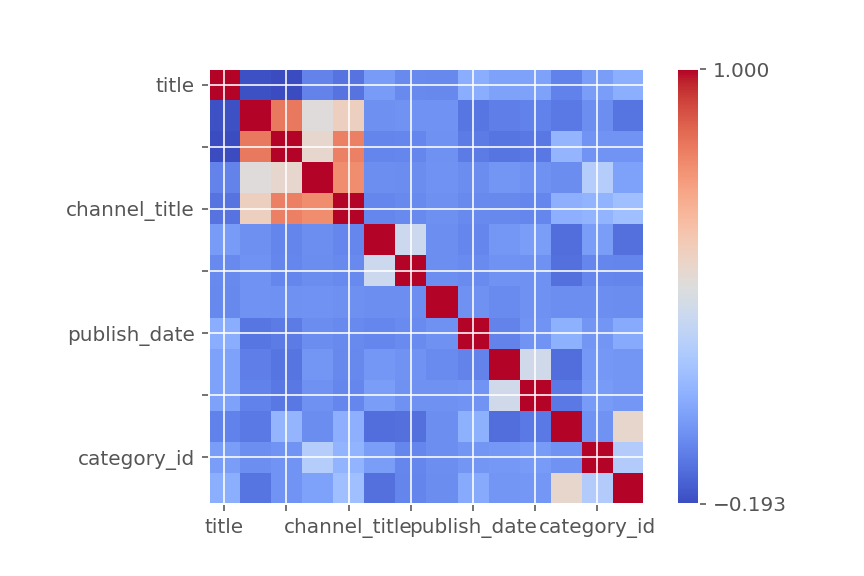

In [43]:
fig, ax = plt.subplots()

heatmap = ax.imshow(corr_matrix, interpolation='nearest', cmap=cm.coolwarm)

cbar_min = corr_matrix.min().min()
cbar_max = corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

labels=['']
for column in ENG_df[0:-1]:
    labels.append(column)
    labels.append('')
ax.set_yticklabels(labels,minor=False)
ax.set_xticklabels(labels, minor=False)

plt.show()

In [46]:
ENG_df['category_name'] = np.nan

ENG_df.loc[(ENG_df["category_id"] == 1),"category_name"] = 'Film and Animation'
ENG_df.loc[(ENG_df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
ENG_df.loc[(ENG_df["category_id"] == 10),"category_name"] = 'Music'
ENG_df.loc[(ENG_df["category_id"] == 15),"category_name"] = 'Pets and Animals'
ENG_df.loc[(ENG_df["category_id"] == 17),"category_name"] = 'Sport'
ENG_df.loc[(ENG_df["category_id"] == 19),"category_name"] = 'Travel and Events'
ENG_df.loc[(ENG_df["category_id"] == 20),"category_name"] = 'Gaming'
ENG_df.loc[(ENG_df["category_id"] == 22),"category_name"] = 'People and Blogs'
ENG_df.loc[(ENG_df["category_id"] == 23),"category_name"] = 'Comedy'
ENG_df.loc[(ENG_df["category_id"] == 24),"category_name"] = 'Entertainment'
ENG_df.loc[(ENG_df["category_id"] == 25),"category_name"] = 'News and Politics'
ENG_df.loc[(ENG_df["category_id"] == 26),"category_name"] = 'How to and Style'
ENG_df.loc[(ENG_df["category_id"] == 27),"category_name"] = 'Education'
ENG_df.loc[(ENG_df["category_id"] == 28),"category_name"] = 'Science and Technology'
ENG_df.loc[(ENG_df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
ENG_df.loc[(ENG_df["category_id"] == 25),"category_name"] = 'News & Politics'

<IPython.core.display.Javascript object>


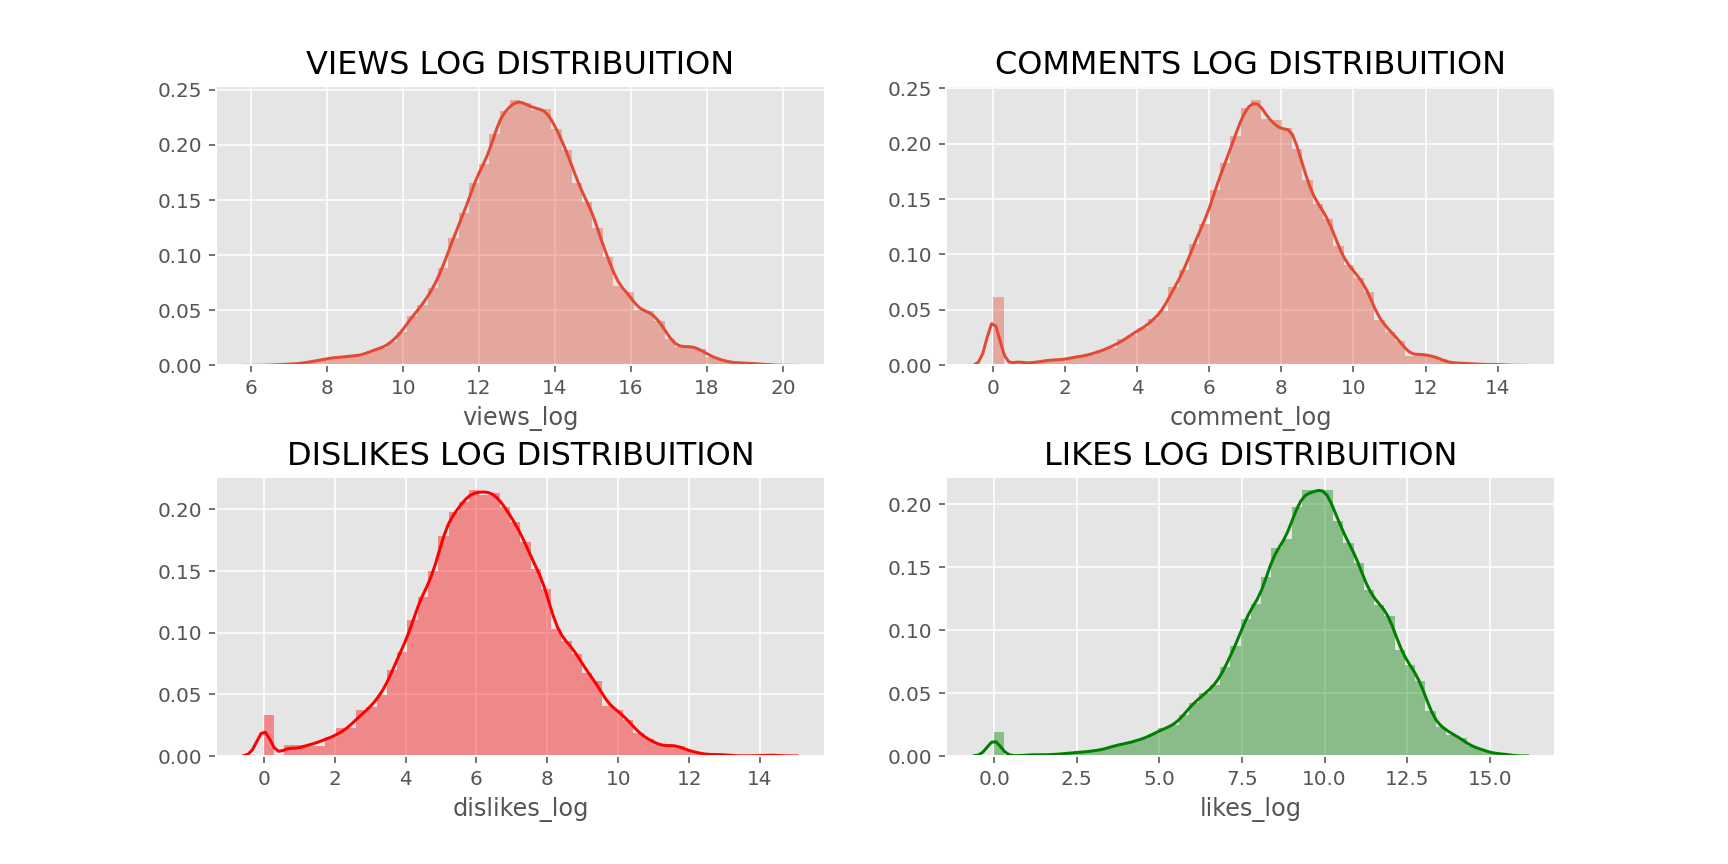

'\nViews, Comments, Dislikes and Likes are all normally distributed.\n'

In [50]:
ENG_df['likes_log'] = np.log(ENG_df['likes'] + 1)
ENG_df['views_log'] = np.log(ENG_df['views'] + 1)
ENG_df['dislikes_log'] = np.log(ENG_df['dislikes'] + 1)
ENG_df['comment_log'] = np.log(ENG_df['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(ENG_df['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(ENG_df['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(ENG_df['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(ENG_df['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

'''
Views, Comments, Dislikes and Likes are all normally distributed.
'''

<IPython.core.display.Javascript object>


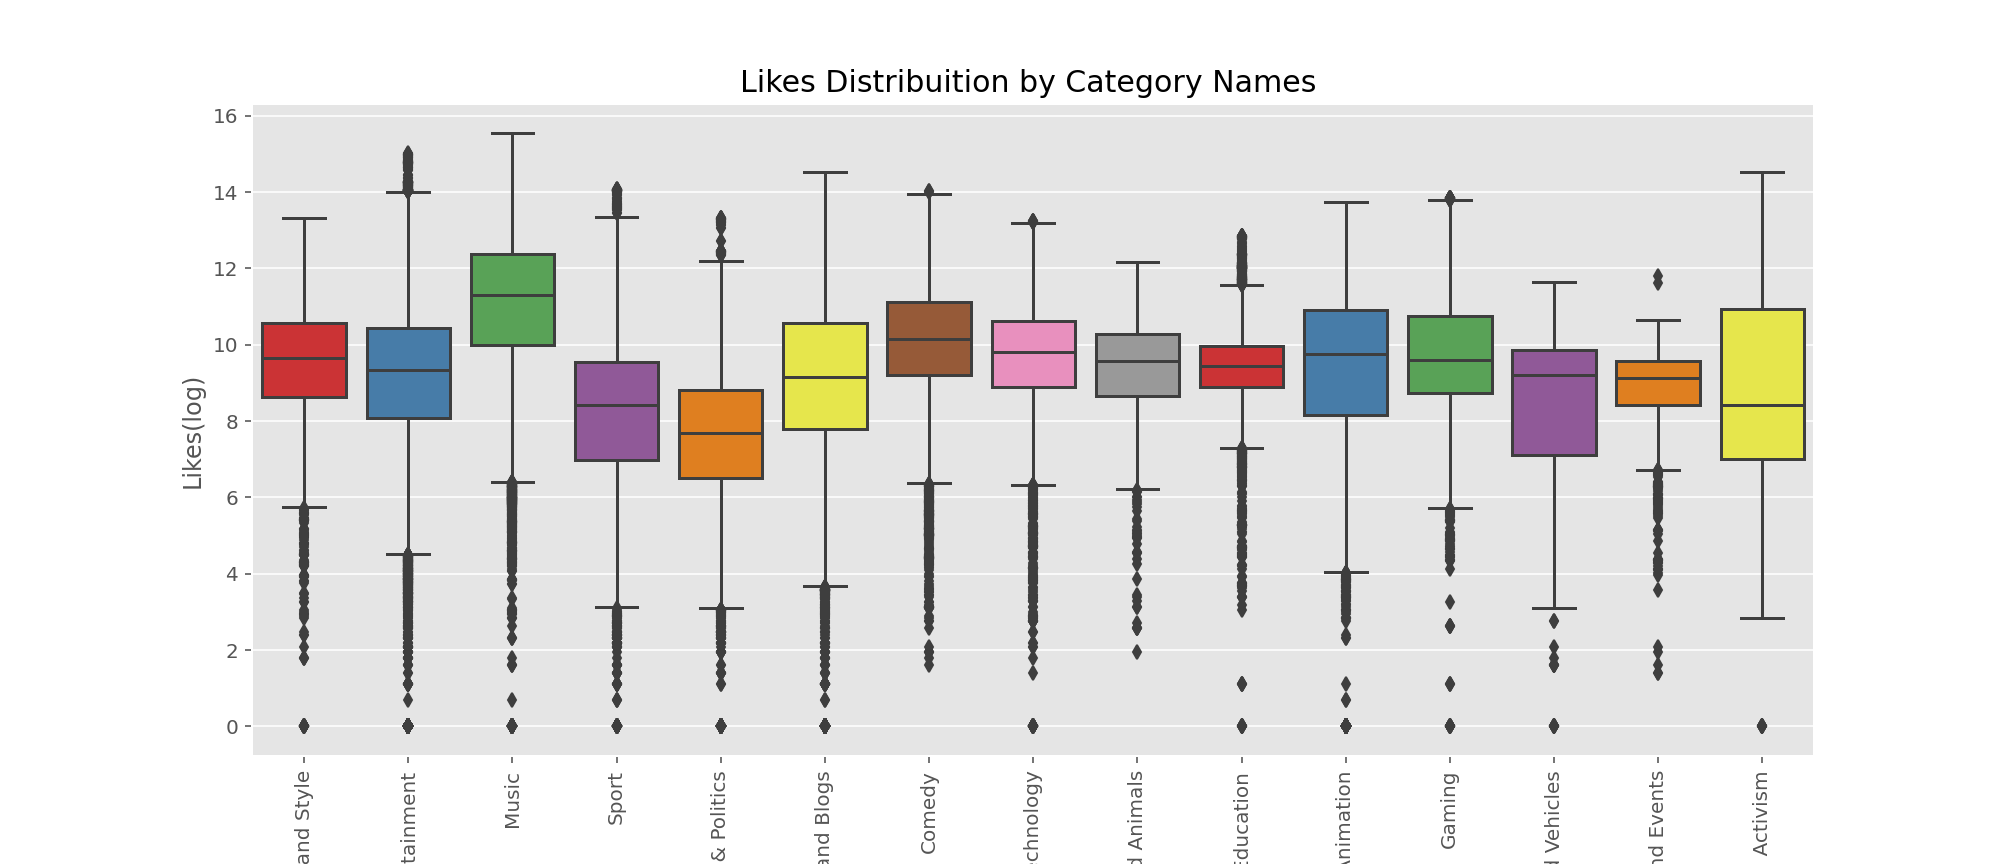

In [51]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likes_log', data=ENG_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Likes Distribuition by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


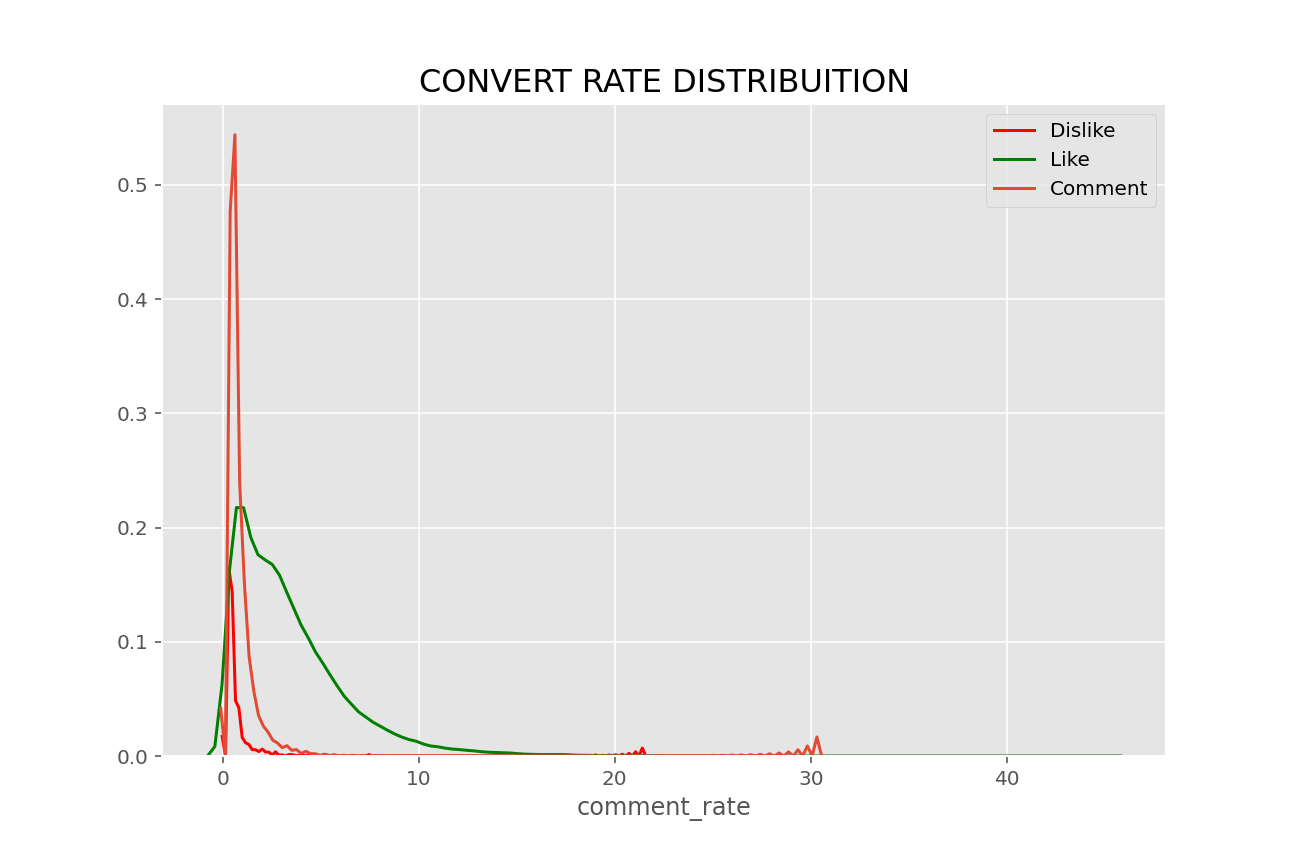

In [52]:
ENG_df['like_rate'] =  ENG_df['likes'] / ENG_df['views'] * 100
ENG_df['dislike_rate'] =  ENG_df['dislikes'] / ENG_df['views'] * 100
ENG_df['comment_rate'] =  ENG_df['comment_count'] / ENG_df['views'] * 100

plt.figure(figsize = (9,6))

g1 = sns.distplot(ENG_df['dislike_rate'], color='red',hist=False, label="Dislike")
g1 = sns.distplot(ENG_df['like_rate'], color='green',hist=False, label="Like")
g1 = sns.distplot(ENG_df['comment_rate'],hist=False,label="Comment")
g1.set_title('CONVERT RATE DISTRIBUITION', fontsize=16)
plt.legend()
plt.show()

TOP 5 Hour values
16    10889
17    10065
15     9176
18     7517
14     7374
Name: hour, dtype: int64


<IPython.core.display.Javascript object>


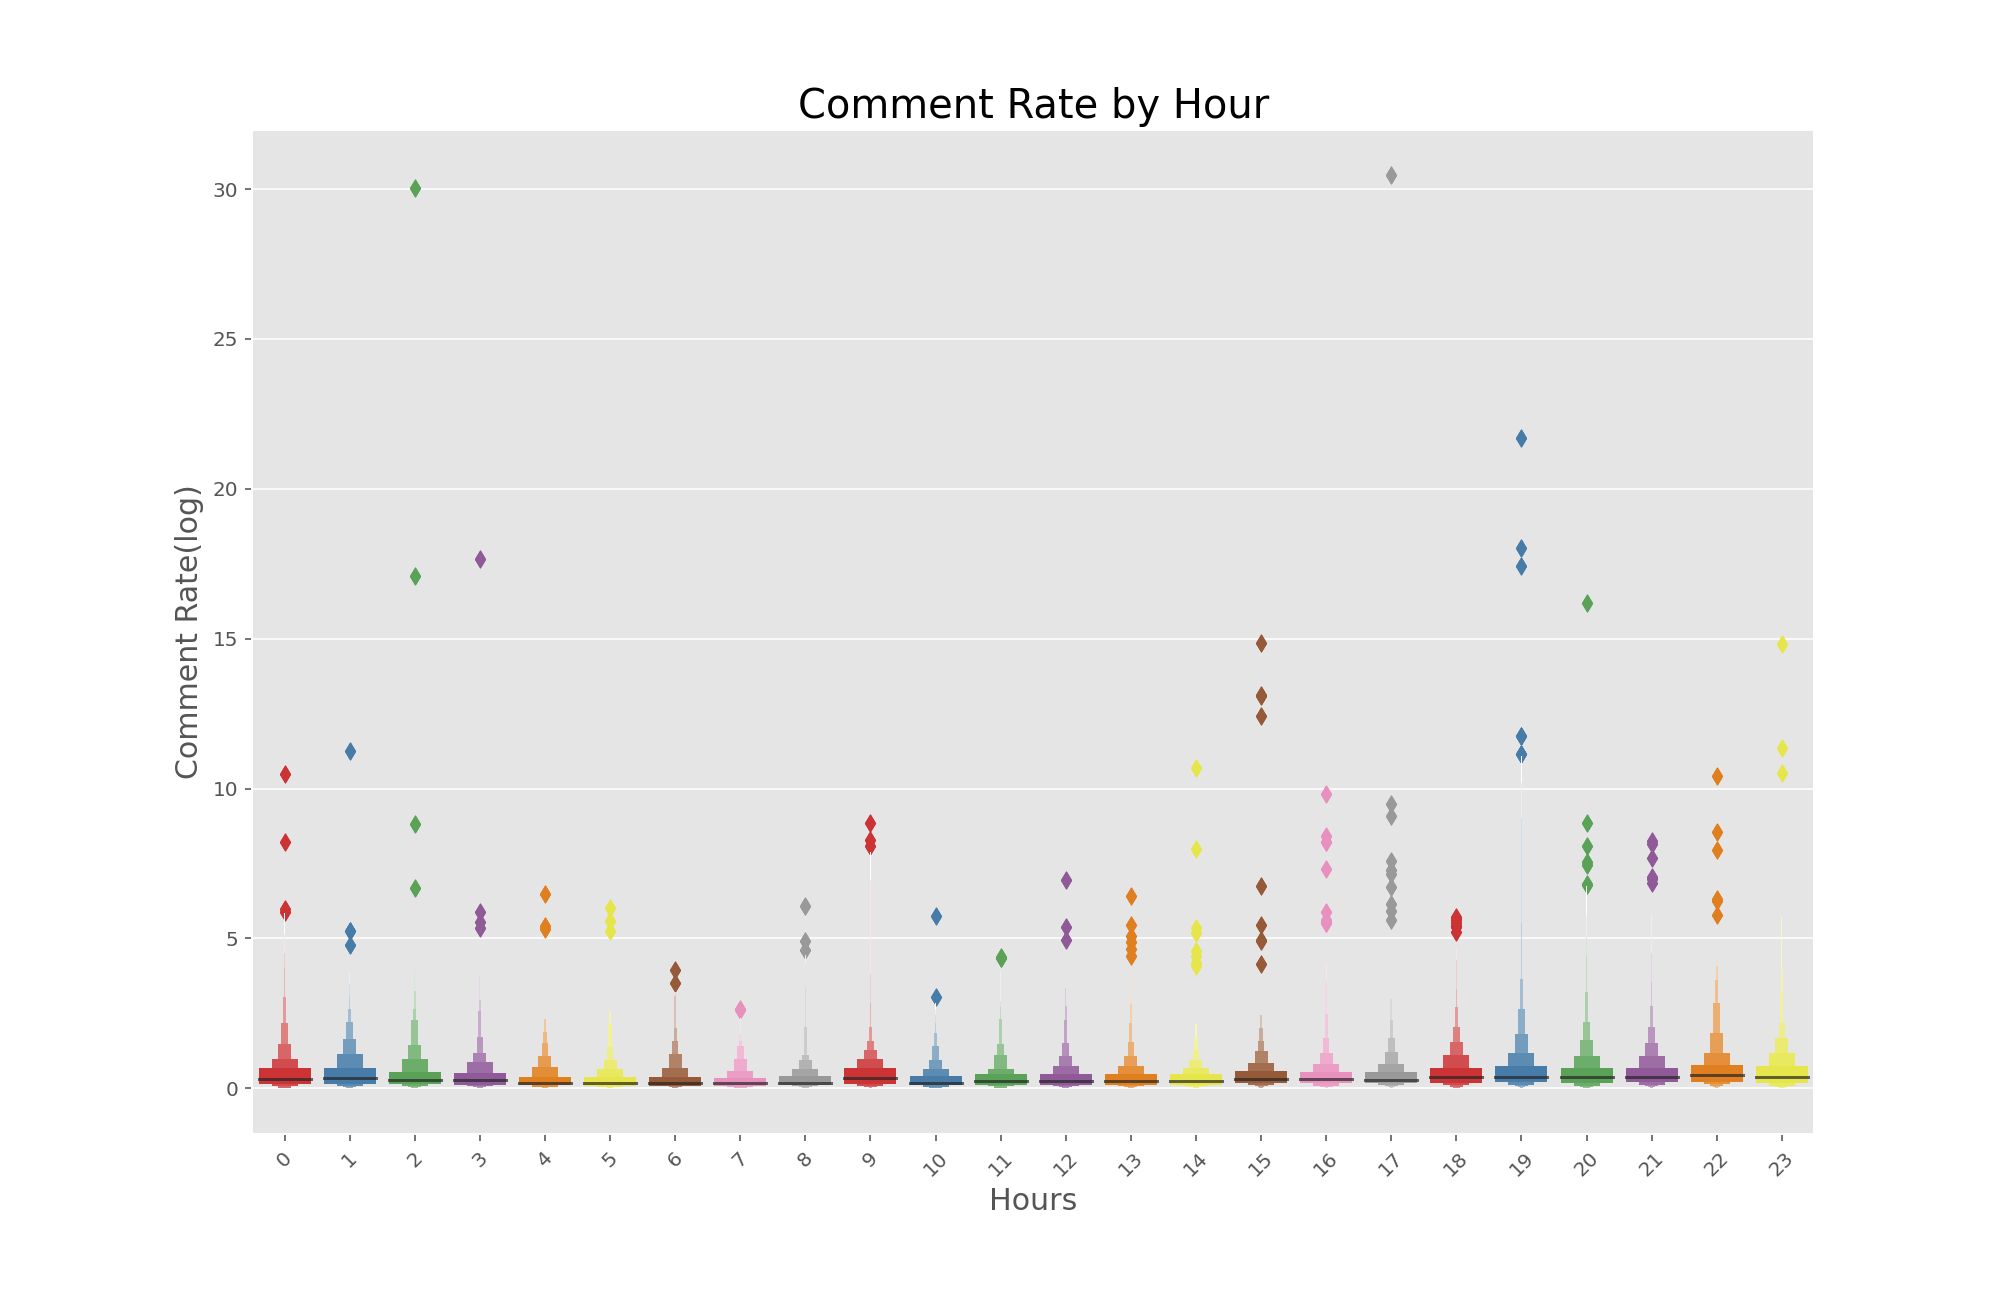

In [63]:
print("TOP 5 Hour values")
print(ENG_df['hour'].value_counts()[:5])

plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=ENG_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=ENG_df, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

In [65]:
plt.figure(figsize = (14,9))

plt.subplot(111)
g2 = sns.lvplot(x='hour', y='comment_rate', data=ENG_df, palette="Set1")
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("Comment Rate by Hour", fontsize=20)
g2.set_xlabel("Hours", fontsize=15)
g2.set_ylabel("Comment Rate(log)", fontsize=15)

plt.show()